In [67]:
import json
import torch
import torch.nn as nn
from torch.utils.data import RandomSampler
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import load_im
from models.vae import VAE

batch_size = 64
learning_rate = 1e-3
data_path = 'data/omniglot'
num_epochs = 100
dataset_size = 20000

model_name = 'conv_vae_omniglot'
resume_epoch = 0

In [68]:
def save_model_checkpoint(model, name, epoch):
    torch.save(model.state_dict(), f'models/compressor/{name}_epoch{epoch}.pth')

def load_dataset(data_path, dataset_size=5000, batch_size=64):
    print(f'Loading data from {data_path}...')
    train_dataset = datasets.ImageFolder(
        root=data_path,
        transform= transforms.Compose([transforms.Grayscale(), transforms.Resize((64, 64)), transforms.ToTensor()])
    )
    train_dataset_size_full = len(train_dataset.samples)
    print(f'{train_dataset_size_full} samples found. Sampling {dataset_size} for training.')

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        sampler=RandomSampler(train_dataset, replacement=True, num_samples=dataset_size)
    )
    return train_loader

def loss_function(recon_x, x, mu, logsigma):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')   # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())       # KL divergence
    return BCE + KLD, BCE, KLD

def train(model, data_path, dataset_size=5000, batch_size=64, num_epochs=5, learning_rate=1e-3):
    train_loader = load_dataset(data_path, dataset_size, batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    outputs = []
    for epoch in range(resume_epoch, num_epochs):
        train_loss = 0
        for i, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x = batch[0].cuda()
            recon_batch, mu, logsigma = model(x)
            loss, _, _ = loss_function(recon_batch, x, mu, logsigma)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            # progress
            pct = (i*batch_size/dataset_size)*100.0
            print('\r[ %.2f%% ]' % round(pct, 2), end='', flush=True)

        train_loss_mean = float(train_loss)/dataset_size
        print('\nEpoch:{}, Loss:{:.4f}'.format(epoch+1, train_loss_mean))
        outputs.append((epoch, x, recon_batch),)

        # save checkpoint
        save_model_checkpoint(model, model_name, epoch)

    print('Finished!')
    save_model_checkpoint(model, model_name, epoch)
    return outputs

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight, gain=1.0)
        m.bias.data.fill_(0.01)

In [69]:
# Training
with open('config/creature.json') as f:
    config = json.load(f)
    latent_size = config.get('vae.latent.size')

torch.manual_seed(1)
model = VAE(latent_size)

model_checkpoint_path = f'models/compressor/{model_name}_epoch{resume_epoch}.pth'
if (os.path.exists(model_checkpoint_path)):
    model.load_state_dict(torch.load(model_path))
else:
    model.apply(init_weights)

model.cuda()
print(model)

train(
    model=model, 
    data_path=data_path, 
    dataset_size=dataset_size, 
    batch_size=batch_size, 
    num_epochs=num_epochs, 
    learning_rate=learning_rate
)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (fc_mu): Linear(in_features=1024, out_features=64, bias=True)
    (fc_logsigma): Linear(in_features=1024, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
  )
)
Loading data from data/omniglot...
32460 samples found. Sampling 20000 for training.
[ 99.84% ]
Epoch:1, Loss:909.2850
[ 99.84% ]
Epoch:2, Loss:646.4900
[ 99.84% ]
Epoch:3, Loss:513.9253


KeyboardInterrupt: 

Loaded VAE model models/compressor/conv_vae_07_07_2020.pth from disk
loss: 1727.5394287109375
bce: 1699.385498046875
kld:28.153972625732422


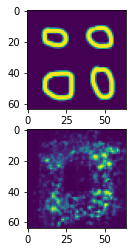

In [64]:
# Inference
with open('config/creature.json') as f:
    config = json.load(f)
    model_path = 'models/compressor/conv_vae_07_07_2020.pth'
    latent_size = config.get('vae.latent.size')

model = VAE(latent_size)
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()

print(f'Loaded VAE model {model_path} from disk')
#print(model)

im_orig = load_im('data/validate/test.png')
im = np.reshape(im_orig, (1, 1, 64, 64))	
im = torch.from_numpy(im).cuda()

im_recon, mu, logsigma = model.cuda().forward(im)
loss, bce, kld = loss_function(im_recon, im, mu, logsigma)
print(f'loss: {loss}\nbce: {bce}\nkld:{kld}')
im_out = np.reshape(im_recon.cpu().detach().numpy(), (64, 64))

fig, ax = plt.subplots(2, 1)
plt.subplot(211)
plt.imshow(im_orig)
plt.subplot(212)
plt.imshow(im_out)
plt.show()